# News discover
## Author: Li Liu (ll782)

## Data source:
Collect data by News API, it is a simple and easy-to-use API that returns JSON metadata for the headlines currently published on a range of news sources.

A python script, read top/latest news from every source. data set includes attibutes of author, description, publishedAt, source, title, url, urlToImage, category, scraping_date. Furthermore, to reduce the data noise, scraping script support deduplication and null data removal, and save data into a csv file.

With the help of python lib newspaper3k, full text could be retrieved from url. Here only the short description is used for basic analysis, since description typically includes important information in the news.

## Environment
* Pyspark driven by Jupyter notebook
* anaconda python 3.5 integrated with:
    * nltk
    * sklearn
    * numpy
    * pandas
    * matplotlib
    

### Loading data into spark
Reading csv file into pandas dataframe, and then tranform it into spark dataframe. Although pandas dataframe has user friendly UI interface, to leverage spark in-memory map reduce computing power, data have to be loaded in RDD or spark dataframe. In this project, for showing results or invoking sklearn function which is not provided by pyspark, there is some convertion between pandas and spark dataframe.

In [1]:
import findspark
findspark.init()
import pyspark
import random
from pyspark.sql import SQLContext, Row
from pyspark.sql.functions import col, length, udf
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *
import csv
import pandas as pd

In [2]:
# from csv import reader
sc = pyspark.SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

# pandas for data manipulation
pd.options.mode.chained_assignment = None


# csv file path
input_file_path = '/Users/liliu/workspace/newsapi/news_full_key_ner.csv'
output_file_path = '/Users/liliu/workspace/newsapi/news_clusterd_by_keywords_named_entities.csv'

data = pd.read_csv(input_file_path)

# Important merge keywords and named_entities to new columns
data["keywords_named_entities"] = data["keywords"]+'\n'+ data["named_entities"].fillna('')
# Important add doc_id to track document for labling topic
data['doc_id'] = data.index

# column name chosen for text analysis
text_col = 'keywords_named_entities'

schema = StructType([StructField('author',StringType(),True),
                     StructField('description',StringType(),True), 
                     StructField('publishedAt',StringType(),True),
                     StructField('source',StringType(),True),
                     StructField('title',StringType(),True),
                     StructField('url',StringType(),True),
                     StructField('urlToImage',StringType(),True),
                     StructField('category',StringType(),True),
                     StructField('scraping_date',StringType(),True),
                     StructField('fulltext',StringType(),True),
                     StructField('keywords',StringType(),True),
                     StructField('named_entities',StringType(),True),
                     StructField('keywords_named_entities',StringType(),True),
                     StructField('doc_id',IntegerType(),True),
                    ])
spdata = sqlContext.createDataFrame(data,schema)



print("total documents:", spdata.count())
print("analysis text in column:", text_col)

total documents: 675
analysis text in column: keywords_named_entities


In [3]:
data[:3]

,author,description,publishedAt,source,title,url,urlToImage,category,scraping_date,fulltext,keywords,named_entities,keywords_named_entities,doc_id
0,ABC News,The U.S. Navy says the search has ended for th...,2017-11-23T00:00:00Z,abc-news,Search ends for 3 US sailors missing in Navy a...,http://abcnews.go.com/International/wireStory/...,http://a.abcnews.com/images/International/Wire...,general,2017-11-24 00:34:00.129124,A search ended Friday for three sailors missin...,pascagoula mississippi\nuss ronald reagan\nfit...,japans\nreagan\nnavy\nuss fitzgerald\nfitzgera...,pascagoula mississippi\nuss ronald reagan\nfit...,0
1,ABC News,Four Dreamers momentarily halted the Macy's Th...,2017-11-23T00:00:00Z,abc-news,Dreamers stage protest during Macy's Thanksgiv...,http://abcnews.go.com/US/dreamers-stage-protes...,http://a.abcnews.com/images/US/daca-2-ht-er-17...,general,2017-11-24 00:34:00.129124,Four Dreamers momentarily halted the Macy's Th...,department of homeland security\ntrump adminis...,new york city\ncongress\nhector martinez\nwhit...,department of homeland security\ntrump adminis...,1
2,ABC News,Some Republicans are hoping lawmakers will soo...,2017-11-23T00:00:00Z,abc-news,Congressional Russia probes likely to head int...,http://abcnews.go.com/Politics/wireStory/congr...,http://a.abcnews.com/images/Politics/WireAP_b8...,general,2017-11-24 00:34:00.129124,Interested in Russia Investigation? Add Russia...,senate intelligence committee\nhouse intellige...,democrat\njared kushner\ndemocratic\ngeorge pa...,senate intelligence committee\nhouse intellige...,2


### Data cleaning
* Remove empty documents
* Remove document with desciprtions less the 100 charactor. Short description typically does not have enough meanful information, which create noise.
* Remove non english news source


In [4]:
spdata = spdata.na.drop()

spdata = spdata.dropDuplicates(['category', 'publishedAt','source','title'])
if text_col == 'description' or text_col == 'fulltext':
    spdata = spdata.filter(length(col(text_col)) > 100)

black_list=['buzzfeed','reddit-r-all','wired-de','gruenderszene','next-big-future','handelsblatt',
'spiegel-online','the-hindu','der-tagesspiegel','abc-news-au',
'mtv-news','the-times-of-india','wirtschafts-woche']
spdata = spdata.filter(spdata.source.isin(*black_list) == False)
print("Total valid documents:", spdata.count())

Total valid documents: 665


In [5]:
%matplotlib inline
# pandas for data manipulation
import pandas as pd
pd.options.mode.chained_assignment = None
# nltk for nlp
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
# list of stopwords like articles, preposition
stop = set(stopwords.words('english'))
from string import punctuation
from collections import Counter
import re
import numpy as np


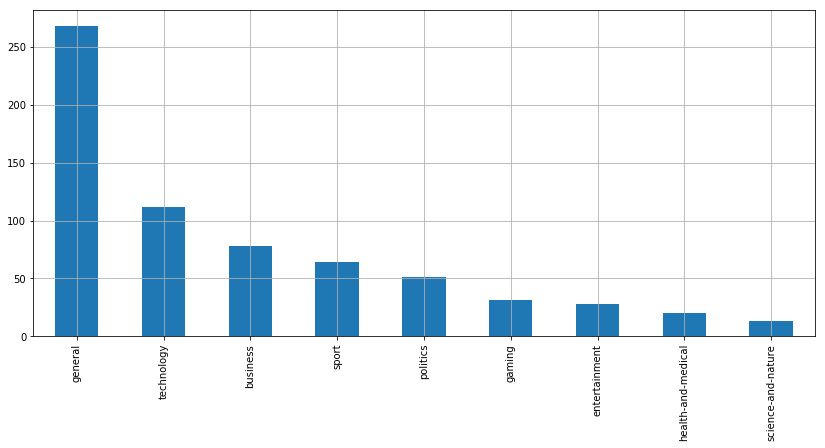

In [6]:
data = spdata.toPandas()
data.category.value_counts().plot(kind='bar', grid=True, figsize=(14, 6))

### News category analysis
From catergory histgram, it is clear to see most news articles are in the general category. And sport, business, enterainment and technology are people intered category.

Category just gives the basic infomation about articles, but to understand each documents' topic is a problem. After Examing the data from general category, news in general category are mixed topics. News articles classification only identify the article belongs to which category. But it cannot tell the topic and key infomation of the article.


### Key information extraction problem
Assuming each document contains a set of key information related a topic. Documents belongs to same topic, should have high similar of key information. Therefore, extract key information for each documents is the foundation for topics clustering.

This project is focus on how to extract key information from a news article.



#### 1. Tokenize documents is the first step to extract key words, follow natural language processing steps:
 - Split the documents into sentences and then split the sentences into tokens
 - Remove punctuation, stop words and special symbol
 - Lowercase all tokens

In [7]:
def keywords_named_entities_tokenizer(text):
    try:
        tokens = text.split('\n')
        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        tokens = list(filter(lambda t: t not in punctuation, tokens))
        filtered_tokens = []
        for token in tokens:
            if token != 'NaN':
                filtered_tokens.append(token)
        return filtered_tokens
    except Exception as e:
        print(e)
        return None

def text_tokenizer(text):
    try:
        tokens_ = [word_tokenize(sent) for sent in sent_tokenize(text)]
        
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent

        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        tokens = list(filter(lambda t: t not in punctuation, tokens))
        tokens = list(filter(lambda t: t not in [u"'s", u"n't", u"...", u"''", u'``', u'ldquo', u'lsquo', u"rsquo", u'rdquo'
                                            u'\u2014', u'\u2026', u'\u2013'], tokens))
        filtered_tokens = []
        for token in tokens:
            if re.search('[a-zA-Z]', token):
                filtered_tokens.append(wordnet_lemmatizer.lemmatize(token))

        filtered_tokens = list(map(lambda token: token.lower(), filtered_tokens))

        return filtered_tokens
    except Exception as e:
        print(e)
        return None

def tokenizer(text):
    keywords_columns=['keywords','named_entities','keywords_named_entities']
    if text_col in keywords_columns:
        return keywords_named_entities_tokenizer(text)
    else:
        return text_tokenizer(text)

In [8]:
sptokenizer = udf(tokenizer, ArrayType(StringType()))
spdata = spdata.withColumn('tokens', sptokenizer(spdata[text_col]))

Tokenizer wrapped by spark user defined function, and applied on every documents, genereate tokens stored in a column called 'tokens'. Here, it fist 5 documents after tokenize:

In [9]:
for row in spdata.head(5):
    print(text_col+':', row[text_col][0:100])
    print('tokens:', row.tokens[0:20])
    print('tokens count:', len(row.tokens))
    print('=================\n')

keywords_named_entities: heiress marjorie merriweather post
trump international golf
coast guard cutters navy
west palm beach
tokens: ['heiress marjorie merriweather post', 'trump international golf', 'coast guard cutters navy', 'west palm beach golf', 'stephanie grisham', 'west palm beach', 'washington post', 'charlottesville', 'international', 'thanksgiving', 'advertisement', 'organization', 'melania trump', 'marshmallows', 'merriweather', 'barack obama', 'assortments', 'teleconference', 'newsletter', 'traditional']
tokens count: 47

keywords_named_entities: the
muchanticipated
pointsgenerating
timespicayune
miami of ohio
headcoaching
bowlwinning
bill johns
tokens: ['muchanticipated', 'pointsgenerating', 'timespicayune', 'miami of ohio', 'headcoaching', 'bowlwinning', 'bill johnson', 'payton mcvay', 'aaron kromer', 'sean paytons', 'candidates', 'offensive', 'experience', 'unwatchable', 'sean payton', 'new orleans', 'highflying', 'trajectory', 'flattering', 'jared goff']
tokens count:

#### 2. Top 10 tokens as key information for each documents
* The number of tokens for a short description is at least 15 words. Full text as description has more than 100 words. Count term frequecy on tokens, and select top 10 most common term as key information.

Here we can see, the top 10 keywords indeed captures the major information about the a topic, but contains a lot common words like 'us', 'one', 'said'.

In [10]:
top_keywords_number = 10
def top_k_keywords(tokens):
    counter = Counter(tokens)
    top_k = counter.most_common(top_keywords_number)
    return [i[0] for i in top_k]

spkeywords = udf(top_k_keywords, ArrayType(StringType()))
spdata = spdata.withColumn('key_tokens', spkeywords(spdata.tokens))
spdata.select(['doc_id','category', 'title', 'key_tokens']).limit(10).collect()


[Row(doc_id=118, category='general', title='A Mar-a-Lago Thanksgiving: It’s All Gravy', key_tokens=['heiress marjorie merriweather post', 'barack obama', 'washington post', 'coast guard cutters navy', 'trump international golf', 'stephanie grisham', 'melania trump', 'charlottesville', 'west palm beach golf', 'west palm beach']),
 Row(doc_id=209, category='sport', title="Sean McVay: I'm not in the same category as Payton", key_tokens=['payton mcvay', 'sean paytons', 'miami of ohio', 'aaron kromer', 'sean payton', 'new orleans', 'bill johnson', 'rams', 'timespicayune', 'pointsgenerating']),
 Row(doc_id=15, category='technology', title='Guidemaster: Want an Alexa device? Here’s every Amazon Echo, compared', key_tokens=['alexa already', 'intel realsense', 'builtin smart home hub alexa', 'alexa', 'amazon amazon', 'ars technica', 'harman kardon', 'spotify iheartradio', 'tweeter', 'amazon']),
 Row(doc_id=482, category='entertainment', title='This professional smartphone camera lens is on sale

### 3. Top 15 tokens in categories
Apply a series of map reduce on spdata to get top 15 key words:
 - Map task generates ( category, token) pairs
 - Redece task collect list of tokens for each category
 - Map task count top k keywords
    
Category general, business and politics contain 'trump' is the top key words as expected.
Since this three category are close related to president's decision.

Technology: ('x', 207), ('iphone', 184), ('apple', 139) in the top list.

Sport: has 'game' 'league' and 'football'

Common words like: 'says' 'said' and 'one' show up in the top list which are undesired.


In [11]:
top_keywords_number = 15
def map_category_keywords(row):
    return (row.category, row.tokens)

def reduce_by_category(all_tokens, tokens):
    return all_tokens + tokens

def map_top_k_keywords(category_tokens):
    counter = Counter(category_tokens[1])
    return (category_tokens[0], counter.most_common(top_keywords_number))
            
category_tokens = spdata.rdd.map(map_category_keywords) \
                        .reduceByKey(reduce_by_category) \
                        .map(map_top_k_keywords) \
                        .collect()

for row in category_tokens:
    print('category :', row[0])
    print('top ' + str(top_keywords_number) + ' key_tokens:', row[1])
    print('\n')

category : health-and-medical
top 15 key_tokens: [('united states', 8), ('researchers', 8), ('university', 6), ('united kingdom', 6), ('conditions', 6), ('complications', 5), ('inflammation', 4), ('medications', 3), ('significant', 3), ('participants', 3), ('international', 3), ('psychological', 3), ('administration', 3), ('underlying', 3), ('kings college london', 2)]


category : science-and-nature
top 15 key_tokens: [('photograph', 5), ('california', 4), ('european', 3), ('thailand', 2), ('fayatteville west virginia', 2), ('mesoamerican', 2), ('glenwood springs colorado', 2), ('glenwood springs', 2), ('littleton colorado', 2), ('instagram ishaygovender', 2), ('carlota da silva', 2), ('christopher columbus', 2), ('democratic', 2), ('researchers', 2), ('palazzo vecchio', 2)]


category : business
top 15 key_tokens: [('donald trump', 17), ('trump', 17), ('new york times', 14), ('administration', 13), ('thanksgiving', 13), ('new york', 11), ('turkey', 11), ('bloomberg', 11), ('american'

### 4. Topic discover
Using TfidfVectorizer to compute similarity between documents and a group of highly related documents form a topic

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

min_df = 5 if text_col == "description" or text_col == "full_text" else 1
print("use %s to calculate tfidf, min_df %d" % (text_col, min_df))
vzdata = spdata.orderBy([spdata.category.desc(), spdata.publishedAt.desc()]).select(['doc_id', text_col,'description','key_tokens','category','publishedAt','url']).toPandas()
vectorizer = TfidfVectorizer(min_df=min_df, max_features=10000, tokenizer=tokenizer, ngram_range=(1, 2))
vz = vectorizer.fit_transform(list(vzdata[text_col]))
vz.shape


use keywords_named_entities to calculate tfidf, min_df 1


(665, 10000)

In [13]:
similarity_matrix = cosine_similarity(vz)
from matplotlib import pyplot as plt

#### 4.1 Similatity between category

From graph we can clearly see there are multiple category, there is low similarity between caregory. 

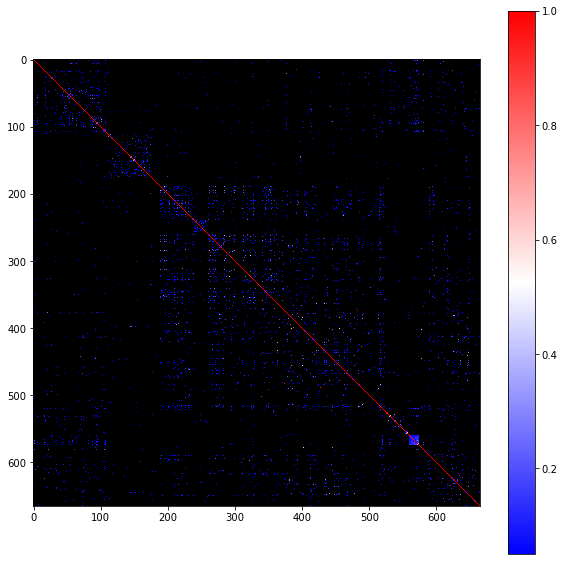

In [14]:
plt.figure(figsize = (10,10))
cmap = plt.cm.bwr
cmap.set_under(color='black') 
plt.imshow(similarity_matrix, cmap=cmap, interpolation='none', vmin=0.05)
plt.colorbar()

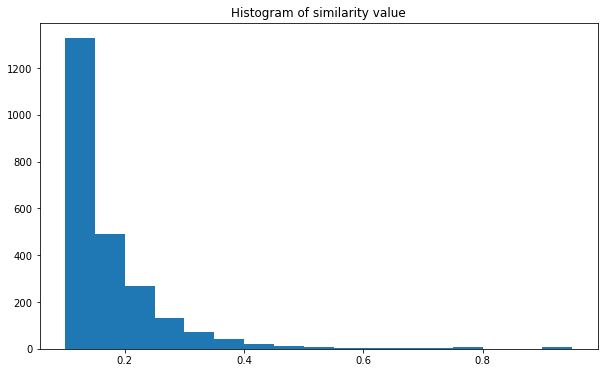

In [15]:
plt.figure(figsize = (10,6))
plt.hist(similarity_matrix.reshape(-1).tolist(), bins=np.arange(0.1, 1.0, 0.05))
plt.title("Histogram of similarity value")

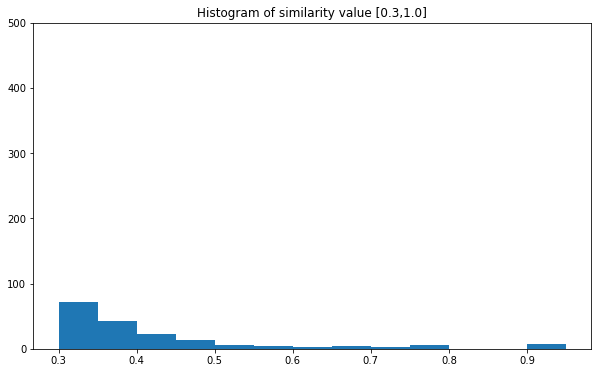

In [32]:
plt.figure(figsize = (10,6))
plt.hist(similarity_matrix.reshape(-1).tolist(), bins=np.arange(0.3, 1.0, 0.05))
plt.ylim(0, 500)
plt.title("Histogram of similarity value [0.3,1.0]")

#### 4.2 High Similatity documents
We define similarity above 0.55 as high similarity documents.

**Document 150** is about topic 'President Donald Trump in Japan', and all related documents also with similar keywords, well fitted in this topic.

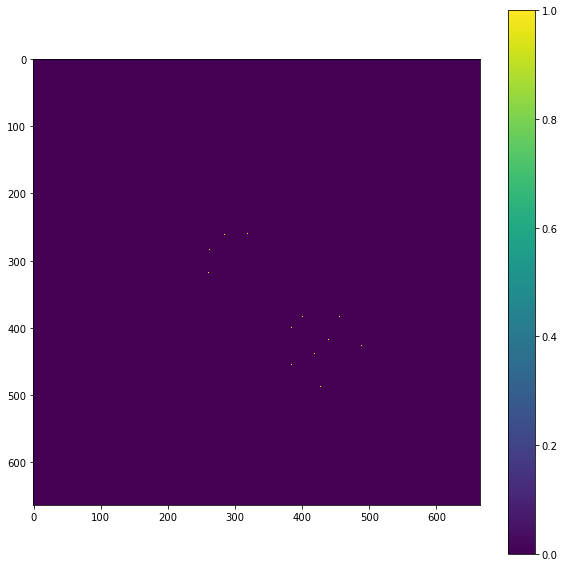

In [16]:
plt.figure(figsize = (10,10))
high_similarity_matrix = np.logical_and( similarity_matrix < 0.99 , similarity_matrix.round(decimals=1) >= 0.55)
plt.imshow(high_similarity_matrix, interpolation='none')
plt.colorbar()


In [17]:
from collections import Counter
def sample_similar_docs(similarity_matrix):
    similar_index = np.where(similarity_matrix == True)
    print('first 3 similarity document pairs')
    print(similar_index[0].tolist()[:3])
    print(similar_index[1].tolist()[:3])


    count = Counter(similar_index[0])
    most_common = count.most_common()
    print('\ntop-3 number of similar documents of each documents\n', most_common[:3])

    doc_idx = most_common[0][0]
    
    similarity_doc_index = np.where(similarity_matrix[doc_idx] == True )
    similarity_doc_index = np.append(similarity_doc_index, doc_idx)
    
    print("\ndocument similar to doc: ", doc_idx)
    print("is: ", similarity_doc_index)
    return similarity_doc_index.tolist()


In [18]:
print("high similarity documents:")
similarity_doc_index = sample_similar_docs(high_similarity_matrix)
pd.set_option('display.max_colwidth', 250)
vzdata.iloc[similarity_doc_index]

high similarity documents:
first 3 similarity document pairs
[19, 96, 261]
[96, 19, 319]

top-3 number of similar documents of each documents
 [(384, 2), (611, 2), (323, 1)]

document similar to doc:  384
is:  [400 455 384]


,doc_id,keywords_named_entities,description,key_tokens,category,publishedAt,url
400,26,germanbuilt dieselelectric tr1700\ntestban monitoring organization\nargentinas mar del plata navy\nbritains ministry of defense\nmar del plata argentina ap\nmayra pertossi debora rey\nfernando santilli\nclaudio rodriguez\nitati leguizamon\nhernan...,"MAR DEL PLATA, Argentina (AP) — An apparent explosion occurred near the time and place an Argentine submarine went missing, the country's navy reported Thursday, prompting relatives of the vessel's 44 crew members to burst into tears and some to ...","[victor caivano, testban monitoring organization, mar del plata argentina ap, britains ministry of defense, itati leguizamon, san diegobased, hernan rodriguez, argentine, argentinas mar del plata navy, argentine navy]",general,2017-11-24T00:26:40Z,https://apnews.com/9d23c32780684f7ba0a513cca44cf799
455,179,mar de plata naval base after argentinas navy\nbritain’s ministry of defense\ngermanbuilt dieselelectric\nmar del plata argentina\nmar de plata argentina\nmar del plata navy\nfernando santilli\nitati leguizamon\ncharacteristics\nhydroacoustic\nar...,Argentina says a sound detected in the search for a missing submarine with 44 crew members aboard is consistent with a non-nuclear explosion.,"[mar de plata naval base after argentinas navy, esteban felix, juan mabromata, mar del plata argentina, mar de plata argentina, itati leguizamon, san diegobased, argentine, argentine navy, mar del plata navy]",general,2017-11-23T15:31:20Z,http://www.nbcnews.com/news/world/argentina-says-sound-detected-sub-search-may-be-explosion-n823616
384,338,testban monitoring organization\nbritain’s ministry of defense\ngermanbuilt dieselelectric\nmar del plata argentina\nmar del plata navy\nfernando santilli\nclaudio rodriguez\nhernan rodriguez\nitati leguizamon\ncharacteristics\ninternational\nhyd...,NaN,"[testban monitoring organization, mar del plata argentina, itati leguizamon, san diegobased, argentine, argentine navy, mar del plata navy, south atlantic, fernando santilli, germanbuilt dieselelectric]",general,2017-11-24T02:07:45Z,http://time.com/5036196/missing-argentine-sub-explosion/?xid=homepage


#### 4.3 Medium similatity documents
We define similarity between 0.35 and 0.55 as medium similarity documents.

From **document 90 to document 100**, they are highly related to a topic. Exam the original documents, the topic is in sport category, all from website www.football-italia.net and all about italia football(to be clear it is soccer). But articles are not talking about an exact same event.


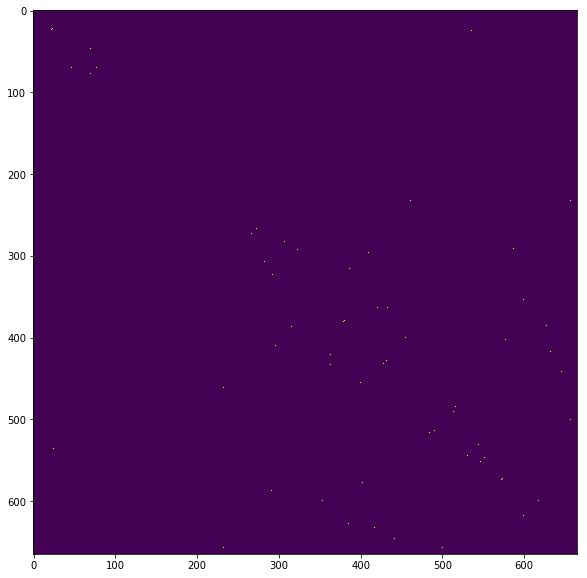

In [19]:
plt.figure(figsize = (10,10))
medium_similarity_matrix = np.logical_and(similarity_matrix < 0.55, similarity_matrix > 0.35)

plt.imshow(medium_similarity_matrix, interpolation='none')


In [20]:
print("medium similarity documents:")
similarity_doc_index = sample_similar_docs(medium_similarity_matrix)
pd.set_option('display.max_colwidth', 250)
vzdata.iloc[similarity_doc_index]

medium similarity documents:
first 3 similarity document pairs
[22, 23, 25]
[23, 22, 536]

top-3 number of similar documents of each documents
 [(596, 3), (599, 3), (315, 2)]

document similar to doc:  596
is:  [353 599 617 596]


,doc_id,keywords_named_entities,description,key_tokens,category,publishedAt,url
353,450,wall street journal the consumer bankers association\nhouse financial services committee jeb hensarling\nelizabeth warren senwarren\npictwittercomr949ccajab\nrealdonaldtrump\nelizabeth warren\ncfpb wall street\nmassachusetts\nrepublicans\nrichard...,"The long, tense history between Republicans and the Consumer Financial Protection Agency.","[doddfrank act, leandra english, senate leandra, cfpb wall street, massachusetts, elizabeth warren senwarren, capitol hill, house financial services committee jeb hensarling, mick mulvaney, wall street journal the consumer bankers association]",general,2017-11-25T02:25:02Z,http://money.cnn.com/2017/11/25/news/wall-street-elizabeth-warren-consumer-financial-protection-bureau/index.html
599,444,american democratic\nelizabeth warren\nobamaappointed\nrichard cordray\nleandra english\nrepublicans\nsouth carolina\nsenate leandra\nnew york times\nadministration\nmassachusetts\ndoddfrank act\nmick mulvaney\nannouncement\nbureaucratic\nprotect...,President Trump on Friday named his budget director as the acting director of the Consumer Financial Protection Bureau.,"[new york times, doddfrank act, leandra english, senate leandra, massachusetts, barack obama, mick mulvaney, south carolina, elizabeth warren, richard cordray]",business,2017-11-25T15:25:59Z,https://www.cnbc.com/2017/11/25/dueling-appointments-lead-to-clash-at-consumer-protection-bureau.html
617,403,obama administration\njustice department\nunavailability\nrichard cordray\nleandra english\nadministration\nmassachusetts\ninstitutions\nmargaret talev\nsenate leandra\nannouncement\nreplacement\nrepublicans\nmick mulvaney\ndirector\nunavailabili...,"President Donald Trump said he is naming White House budget director Mick Mulvaney to be the temporary head of the Consumer Financial Protection Bureau, setting up what could be a high-stakes clash over the regulator’s leadership.","[obama administration, leandra english, donald trump, senate leandra, justice department, massachusetts, margaret talev, barack obama, mick mulvaney, richard cordray]",business,2017-11-25T00:54:40Z,http://www.bloomberg.com/news/articles/2017-11-25/trump-sets-up-clash-over-cfpb-leadership-by-installing-mulvaney
596,424,likes of democratic sen elizabeth warren of massachusetts\nohios democratic gubernatorial nomination\nelizabeth warren senwarren\npictwittercomr949ccajab\ntrump administration\nearlierthanexpected\nsenate doddfrank\nsenateconfirmed\nrichard cordr...,President Donald Trump and outgoing CFPB...,"[senate doddfrank, likes of democratic sen elizabeth warren of massachusetts, doddfrank act, leandra english, senate leandra, ohios democratic gubernatorial nomination, elizabeth warren senwarren, richard cordray, mick mulvaney, trump administrat...",business,2017-11-25T17:39:14Z,http://www.businessinsider.com/consumer-financial-protection-bureau-trump-cordray-cfpb-elizabeth-warren-2017-11


In [21]:
import lda
from sklearn.feature_extraction.text import CountVectorizer
import logging
logging.getLogger("lda").setLevel(logging.WARNING)
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook, ColumnDataSource
output_notebook()
colormap = np.array(["#6d8dca", "#69de53", "#723bca", "#c3e14c", "#c84dc9", "#68af4e", "#6e6cd5",
"#e3be38", "#4e2d7c", "#5fdfa8", "#d34690", "#3f6d31", "#d44427", "#7fcdd8", "#cb4053", "#5e9981",
"#803a62", "#9b9e39", "#c88cca", "#e1c37b", "#34223b", "#bdd8a3", "#6e3326", "#cfbdce", "#d07d3c",
"#52697d", "#7d6d33", "#d27c88", "#36422b", "#b68f79"])

Loading BokehJS ...

In [22]:
min_df = 5 if text_col == "description" or text_col == "full_text" else 3
print("use %s to vectorizer , min_df = %d" % (text_col, min_df))

use keywords_named_entities to vectorizer , min_df = 3


In [23]:
cvectorizer = CountVectorizer(min_df=min_df, max_features=10000, tokenizer=tokenizer, ngram_range=(1,2))
cvz = cvectorizer.fit_transform(list(vzdata[text_col]))

n_topics = 30
print("cluster by %d topic" %(n_topics))
n_iter = 2000
lda_model = lda.LDA(n_topics=n_topics, n_iter=n_iter)
X_topics = lda_model.fit_transform(cvz)

cluster by 30 topic


In [24]:
# Assign topic to each document
doc_topic = lda_model.doc_topic_
lda_keys = []

for i, doc_id in enumerate(list(vzdata['doc_id'])):
    lda_keys += [doc_topic[i].argmax()]
    
vzdata['topic_id'] = lda_keys



In [25]:
import collections
topic_vzdata_idx_dict = collections.defaultdict(list)
topic_doc_dict = collections.defaultdict(list)
for i, topic_id in enumerate(list(vzdata['topic_id'])):
    topic_vzdata_idx_dict[topic_id].append(i)
    topic_doc_dict[topic_id].append(vzdata['doc_id'][i])

n_top_words = 20
topic_summaries = []

topic_word = lda_model.topic_word_  # get the topic words
vocab = cvectorizer.get_feature_names()

for topic_id in topic_doc_dict:
#     print('Topic %d, vzdata_index: %s' % (topic_id, topic_vzdata_idx_dict[topic_id]))
    print('Topic %d\ncsv doc_id: %s' % (topic_id, topic_doc_dict[topic_id]))
    topic_dist = topic_word[topic_id]
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print("top-%d keywords: %s\n" % (n_top_words, ', '.join(topic_words)))

#Note that vzdata_index is different from doc_is, since vzdata is sorted results of csv data

Topic 0
csv doc_id: [386, 454, 608, 385, 467, 512, 434, 575, 657, 372, 620, 664, 619, 438, 72, 230, 642, 643, 445, 443]
top-20 keywords: islamic, egyptian, egypt, muslim brotherhood, responsibility, cairo, sinai peninsula, islamist, abdelfattah elsissi, sufi, iraq, isis, sinai, abdel fattah elsisi, god, egyptians, islamists, russian, ismailia, mohammed morsi

Topic 1
csv doc_id: [563, 223, 52, 615, 581, 373, 527, 393, 651, 432, 374, 668, 346, 294, 185, 5, 350, 139, 404, 425]
top-20 keywords: middle east, american, syria, united states, saudi arabia, iran, trump, washington, syrian, isis, iraq, bashar alassad, new york, pakistan, saudi, arab, donald trump, palestinians, prince mohammed bin salman, kelly

Topic 2
csv doc_id: [203, 204, 31, 108, 168, 170, 338, 122, 26, 293, 285, 179, 333, 81, 324]
top-20 keywords: los angeles chargers, argentine, argentine navy, enrique balbi, dallas cowboys, mar del plata, dallas, fernando santilli, cowboys, keenan allen, san juan, ezekiel elliott, navy,

In [26]:

csv_to_save = data.merge(vzdata.loc[:,['doc_id','topic_id']], left_on='doc_id', right_on='doc_id', how='inner')
csv_to_save = csv_to_save.sort_values(by=['doc_id'])
#save clustered results
csv_to_save.to_csv(output_file_path, encoding='utf-8', index=False)

In [27]:
csv_to_save.query('topic_id==14')

,author,description,publishedAt,source,title,url,urlToImage,category,scraping_date,fulltext,keywords,named_entities,keywords_named_entities,doc_id,topic_id
476,ANDREW MELDRUM,"JOHANNESBURG (AP) — Zimbabwe's incoming leader Emmerson Mnangagwa, widely known as the Crocodile, is seen as a smart, ruthless politician, and many question if he will be able to bring the change the country craves. ""We are witnessing the beginni...",2017-11-24T00:26:56Z,associated-press,"Zimbabwe asks if new leader, a Mugabe ally, can bring change",https://apnews.com/2bbf7e8be95940e3bfa0ac91978db601,https://storage.googleapis.com/afs-prod/media/media:f1ecade36bd7414781d34dd9ee6b1b91/3000.jpeg,general,2017-11-24 00:34:00.129124,"JOHANNESBURG (AP) — Zimbabwe's new president Emmerson Mnangagwa, widely known as the Crocodile, is seen as a smart, ruthless politician, but many question if he will be able to bring the change the country craves.\n\n""We are witnessing the beginn...",armys north koreantrained fifth brigade mnangagwa\nemmerson mnangagwa\nmorgan tsvangirai\ntichaona zindoga\njohannesburg\nlovemore matuke\nstaterun herald\ninternational\nunited nations\nmugabe\nheadquarters\ncorrespondence\nrobert mugabe\ndemons...,london\nmorgan tsvangirai\nunited nations\nmozambique\nnkomos\nmnangagwa\njohannesburg\narmys north koreantrained fifth brigade mnangagwa\nmatabeleland\njoshua nkomo\negypt\nafrica\nemmerson mnangagwa\nrobert mugabe\nrhodesia\nzimbabwe\ncongo\nrh...,armys north koreantrained fifth brigade mnangagwa\nemmerson mnangagwa\nmorgan tsvangirai\ntichaona zindoga\njohannesburg\nlovemore matuke\nstaterun herald\ninternational\nunited nations\nmugabe\nheadquarters\ncorrespondence\nrobert mugabe\ndemons...,25,14
107,MacDonald Dzirutwe,"Emmerson Mnangagwa will cap a stunning political comeback when he is sworn in as Zimbabwe's president on Friday, bringing the final curtain down on the 37-year rule of Robert Mugabe.",2017-11-23T23:18:55Z,reuters,"Mnangagwa the ""Crocodile"" to be sworn in as Zimbabwe's president",http://feeds.reuters.com/~r/reuters/topNews/~3/-SpO9bBxxUc/mnangagwa-the-crocodile-to-be-sworn-in-as-zimbabwes-president-idUSKBN1DN29H,https://s3.reutersmedia.net/resources/r/?m=02&d=20171123&t=2&i=1211023713&w=&fh=545px&fw=&ll=&pl=&sq=&r=LYNXMPEDAM16L,general,2017-11-24 00:34:00.129124,"HARARE (Reuters) - New President Emmerson Mnangagwa laid out a grand vision on Friday to revitalise Zimbabwe’s ravaged economy and vowed to rule on behalf of all the country’s citizens.\n\nSworn in days after the overthrow of Robert Mugabe, the 7...",southern african development community an intergovernmental organization\nnorth koreantrained fifth brigade mnangagwa\nchombo separately high court\nnational stadium mnangagwa\nreutersmike hutchings\nemmerson mnangagwa\nlovemore madhuku\nintergov...,mugabe grace\ngukurahundi\nshona\nzimbabwean\ndemocratic\nlenin tongoona\nchombo separately high court\ngeorge chiweshe\nlovemore madhuku\nreutersmike hutchings\nwestern\nwest\nmnangagwa\nignatius chombo\nmatabeleland\nharare reuters\nreuters\nso...,southern african development community an intergovernmental organization\nnorth koreantrained fifth brigade mnangagwa\nchombo separately high court\nnational stadium mnangagwa\nreutersmike hutchings\nemmerson mnangagwa\nlovemore madhuku\nintergov...,253,14
510,"Farai Mutsaka, Christopher Torchia / AP",NaN,2017-11-24T01:37:59Z,time,"Robert Mugabe Won't Face Prosecution, Zimbabwe's Ruling Party Says",http://time.com/5036197/robert-mugabe-zimbabwe-resign-prosecution/?xid=homepage,https://timedotcom.files.wordpress.com/2017/11/gettyimages-1772026451.jpg?quality=85,general,2017-11-24 00:34:00.129124,"(HARARE, Zimbabwe) — Zimbabwe’s ruling party assured Robert Mugabe that he wouldn’t be prosecuted if he resigned, a party official said Thursday, as the fate of the 93-year-old became clearer and the country prepared to move on.\n\n“Prosecuting h...",emmerson mnangagwa\ndejectedlooking\nlovemore matuke\nharare zimbabwe\nantigover

### visualization of LDA clustering

In [28]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_lda = tsne_model.fit_transform(X_topics)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 665 samples in 0.002s...
[t-SNE] Computed neighbors for 665 samples in 0.030s...
[t-SNE] Computed conditional probabilities for sample 665 / 665
[t-SNE] Mean sigma: 0.227345
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.662804
[t-SNE] Error after 1000 iterations: 0.675780


In [29]:
plot_lda = bp.figure(plot_width=700, plot_height=700, title="LDA topic visualization",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

In [30]:
lda_data_source = csv_to_save

lda_df = pd.DataFrame(tsne_lda, columns=['x','y'])

lda_df['doc_id'] = list(lda_data_source['doc_id'])
lda_df['description'] = list(lda_data_source['description'])
lda_df['category'] = list(lda_data_source['category'])
if text_col != 'fulltext' and text_col != 'description':
    lda_df['text_col'] = list(lda_data_source[text_col])

colormap60 = np.concatenate((colormap, colormap)) 
lda_df['color'] = colormap60[lda_keys]

lda_df['topic'] = lda_keys
lda_df['topic'] = lda_df['topic'].map(int)

plot_lda.scatter(source=lda_df, x='x', y='y', color='color')

hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips={"description":"@description", "topic":"@topic", "category":"@category", "doc_id":"@doc_id"}
# hover.tooltips={"text_col": "@text_col", "description":"@description", "topic":"@topic", "category":"@category", "doc_id":"@doc_id"}

    
show(plot_lda)

## Conclusion: common keywords problem

As stated before, the key information extraction is the foundation of topic clustering.
* Extraction sololy based on term frequency contains large amount commone words.
* Tf-idf similarity of full text documents provide limit feature for clusting topics. 
* Only high similarity documents belongs to a topic.

Next step is use a key informatin extraction model to improve documents similarity.

## Future work
* The proposed key word extraction model based on terms' features: noun, named entity, wiki words, capitalized, tf, tf-idf, position, also in title, etc.

* Documents key infomation include extracted key words and also should input geo entiry and time infomation. 

* Dataset https://github.com/zelandiya/keyword-extraction-datasets.

## Acknowledge
1. https://newsapi.org/
2. https://gist.github.com/ahmedbesbes/4597996515e4bb7961825d4c13ea6aff#file-news-py
3. http://www.nltk.org/
4. https://github.com/zelandiya/keyword-extraction-datasets
5. http://pythonhosted.org/lda/
6. https://github.com/lvsh/keywordfinder